In [ ]:
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project_main/data_csv/pca_with_labels.csv')
print("Loaded:", df.shape)
print(df["Label_simple"].value_counts().head(10))
print("\nClassification BENIGN vs DoS preparation")


Loaded: (2829385, 11)
Label_simple
BENIGN          2272688
DoS              251712
PortScan         158930
DDoS             128027
Other             17992
Infiltration         36
Name: count, dtype: int64

Classification BENIGN vs DoS preparation


In [ ]:
df_benign = df[df['Label_simple'] == 'BENIGN']
df_dos = df[df['Label_simple'] == 'DoS']
num_dos = len(df_dos)
num_benign = len(df_benign)
print(f"DoS:    {num_dos:,}")
print(f"BENIGN: {num_benign:,}")

DoS:    251,712
BENIGN: 2,272,688


In [ ]:
if num_dos == 0:
    raise ValueError("No DoS samples found!")


In [ ]:
df_benign_undersampled = df_benign.sample(n=num_dos, random_state=42)
print(f"Undersampled BENIGN to: {len(df_benign_undersampled):,} samples to match DoS samples count.")

Undersampled BENIGN to: 251,712 samples to match DoS samples count.


In [ ]:
df_binary_balanced_full = pd.concat([df_dos, df_benign_undersampled], ignore_index=True)
df_binary_balanced_full = df_binary_balanced_full.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
df_binary_balanced_full['Binary_Label'] = (df_binary_balanced_full['Label_simple'] == 'DoS').astype(int)
print("\nFinal dataset label dstribution:")
print(df_binary_balanced_full['Binary_Label'].value_counts())


Final dataset label dstribution:
Binary_Label
1    251712
0    251712
Name: count, dtype: int64


In [ ]:
X = df_binary_balanced_full.drop(columns=['Label_simple', 'Binary_Label'])
y = df_binary_balanced_full['Binary_Label']
print(f"\nShape X: {X.shape}")
print(f"Shape y: {y.shape}")


Shape X: (503424, 10)
Shape y: (503424,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test:  X={X_test.shape},  y={y_test.shape}")

Train: X=(352396, 10), y=(352396,)
Test:  X=(151028, 10),  y=(151028,)


In [ ]:
print("\nTraining Random Forest")
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)


Training Random Forest


RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

In [ ]:
y_pred = rf.predict(X_test)
print("\nClassification Report BENIGN vs DoS:\n")
print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report BENIGN vs DoS:

              precision    recall  f1-score   support

           0     0.9994    0.9992    0.9993     75514
           1     0.9992    0.9994    0.9993     75514

    accuracy                         0.9993    151028
   macro avg     0.9993    0.9993    0.9993    151028
weighted avg     0.9993    0.9993    0.9993    151028

Confusion Matrix:
 [[75454    60]
 [   46 75468]]


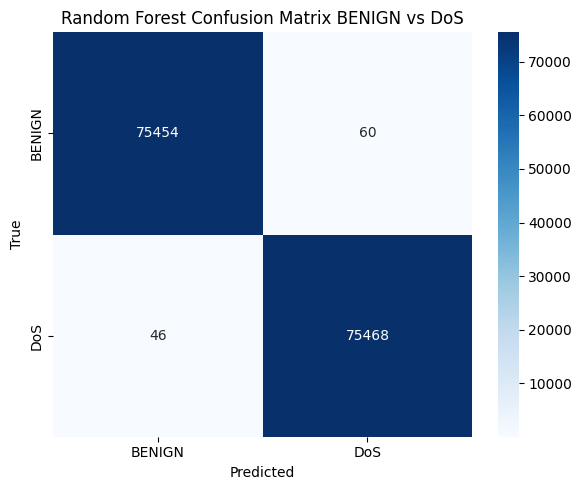

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["BENIGN", "DoS"],
            yticklabels=["BENIGN", "DoS"])
plt.title("Random Forest Confusion Matrix BENIGN vs DoS")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

ROC-AUC: 1.0000


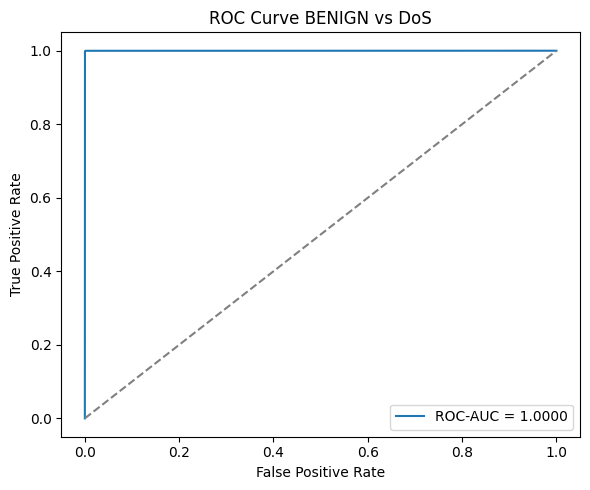

In [ ]:
y_prob = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve BENIGN vs DoS")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
"""Получената стойност на ROC-AUC от 1.0 показва перфектно разделяне между нормалния (Benign) и DoS трафика в пространството на редуцираните характеристики. Този резултат може да се обясни с ясно изразените и специфични характеристики на DoS атаките в набора от данни CICIDS2017, както и с прилагането на метода за главни компоненти (PCA) преди разделянето на данните на обучаващ и тестов набор, което може да доведе до определена степен на изтичане на информация (information leakage). Поради тази причина, въпреки че резултатите демонстрират силната дискриминативна способност на избраните характеристики и използвания Random Forest модел, те следва да бъдат интерпретирани с повишено внимание.
"""

'Получената стойност на ROC-AUC от 1.0 показва перфектно разделяне между нормалния (Benign) и DoS трафика в пространството на редуцираните характеристики. Този резултат може да се обясни с ясно изразените и специфични характеристики на DoS атаките в набора от данни CICIDS2017, както и с прилагането на метода за главни компоненти (PCA) преди разделянето на данните на обучаващ и тестов набор, което може да доведе до определена степен на изтичане на информация (information leakage). Поради тази причина, въпреки че резултатите демонстрират силната дискриминативна способност на избраните характеристики и използвания Random Forest модел, те следва да бъдат интерпретирани с повишено внимание.\n'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


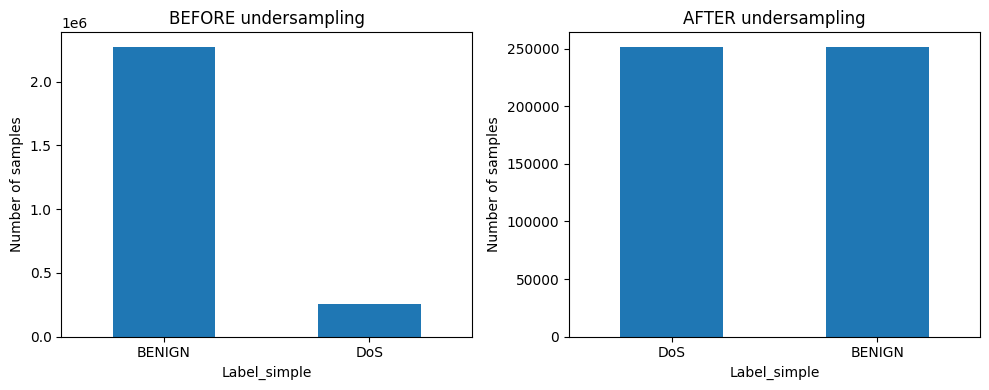

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/project_main/data_csv/pca_with_labels.csv')

df_binary = df[df["Label_simple"].isin(["BENIGN", "DoS"])].copy()

counts_before = df_binary["Label_simple"].value_counts()

df_dos = df_binary[df_binary["Label_simple"] == "DoS"]
df_benign = df_binary[df_binary["Label_simple"] == "BENIGN"]

df_benign_under = df_benign.sample(n=len(df_dos), random_state=42)
df_after = pd.concat([df_dos, df_benign_under])

counts_after = df_after["Label_simple"].value_counts()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
counts_before.plot(kind="bar")
plt.title("BEFORE undersampling")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)

plt.subplot(1,2,2)
counts_after.plot(kind="bar")
plt.title("AFTER undersampling")
plt.ylabel("Number of samples")
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


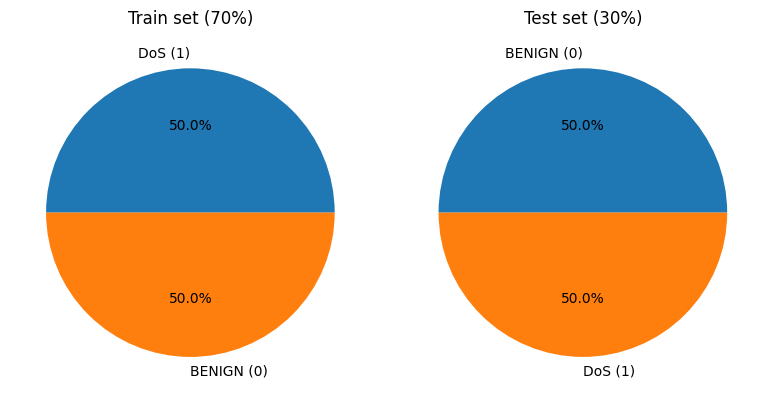

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
y_train.value_counts().rename(index={0:"BENIGN (0)", 1:"DoS (1)"}).plot(kind="pie", autopct="%.1f%%")
plt.title("Train set (70%)")
plt.ylabel("")

plt.subplot(1,2,2)
y_test.value_counts().rename(index={0:"BENIGN (0)", 1:"DoS (1)"}).plot(kind="pie", autopct="%.1f%%")
plt.title("Test set (30%)")
plt.ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
len(rf.estimators_)

300

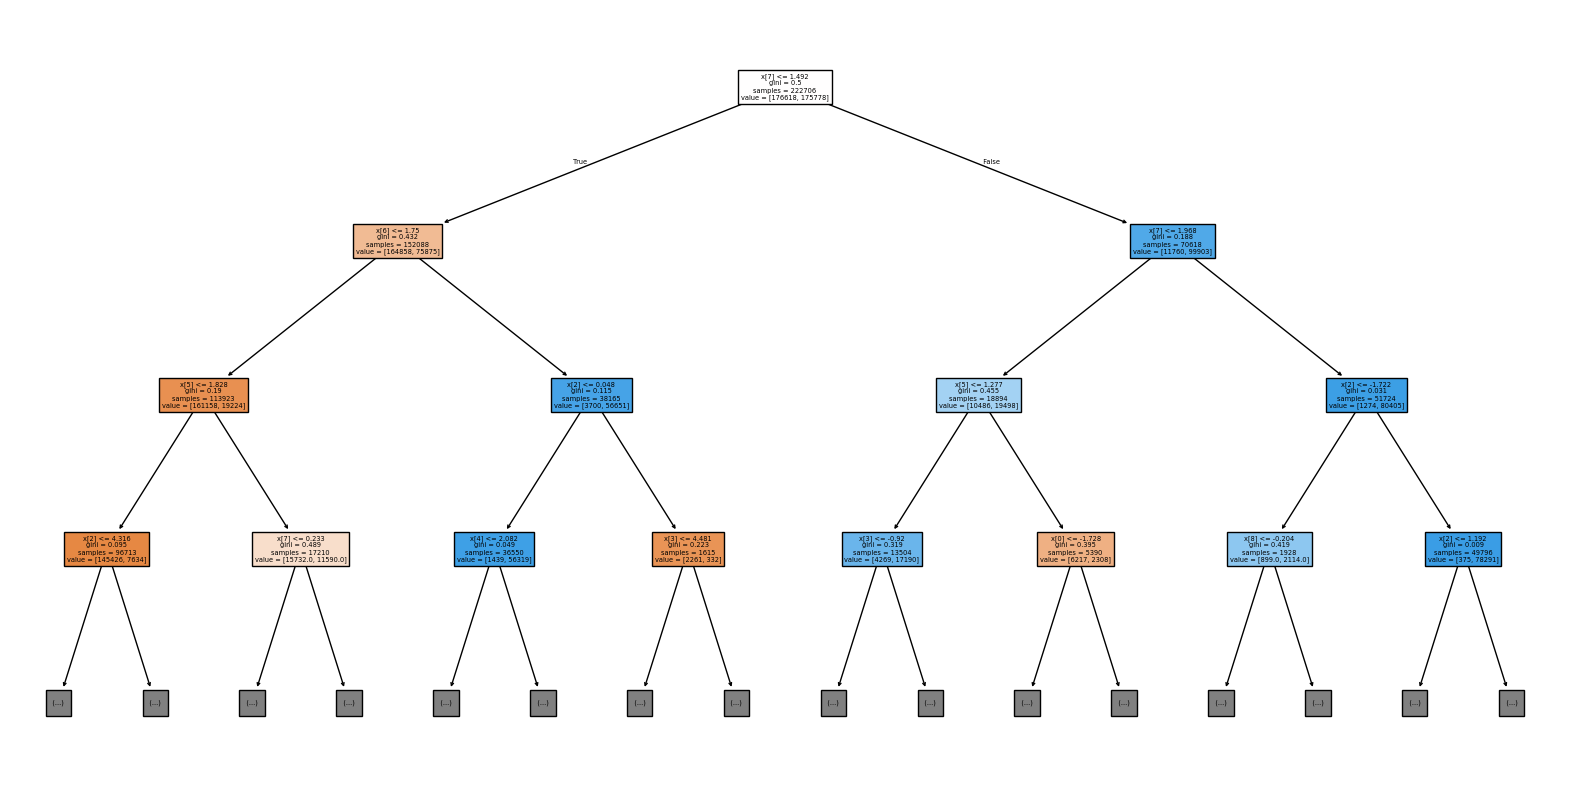

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(rf.estimators_[0], filled=True, max_depth=3)
plt.show()